# **Text mining: SENTIMENT ANALYSIS**

## 🎓 Master’s Program in Data Science & Advanced Analytics  
**Nova IMS** | June 2025  
**Course:** Text Mining

## 👥 Team **Group 34**  
- **[Philippe Dutranoit]** | [20240518]  
- **[Diogo Duarte]** | [20240525]  
- **[Rui luz]** | [20211628]  
- **[Rodrigo Sardinha]** | [20211627]  

## 📊 Goal of the notebook

This notebook focuses on feature selection and engineering for our text-mining project: predicting market sentiment (Bearish, Bullish, Neutral) from Twitter data.  


# Imports

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
X_train = pd.read_csv('../Data/X_train.csv')
y_train = pd.read_csv('../Data/Y_train.csv')
X_test = pd.read_csv('../Data/Data/X_val.csv')
y_test = pd.read_csv('../Data/Y_val.csv')

In [9]:
y_train = y_train['label']
y_test = y_test['label']

In [10]:
print(y_train.head())
print(y_train.unique())

0    2
1    1
2    0
3    0
4    2
Name: label, dtype: int64
[2 1 0]


# Prepocessing

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

X_train['clean_text'] = X_train['text'].apply(clean_text)
X_test['clean_text'] = X_test['text'].apply(clean_text)

In [12]:
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 50

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train['clean_text'])

X_train_seq = tokenizer.texts_to_sequences(X_train['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['clean_text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [13]:
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Feature Engineering → Word Embeddings

In [ ]:
def load_glove_embeddings(filepath, embedding_dim):
    embeddings_index = {}
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

# Load GloVe-Twitter embeddings
embedding_dim = 100
glove_filepath = '../Data/glove.twitter.27B.100d.txt'

embeddings_index = load_glove_embeddings(glove_filepath, embedding_dim)

print(f'Found {len(embeddings_index)} word vectors in GloVe-Twitter.')

# Build Embedding Matrix
embedding_matrix = np.zeros((MAX_NUM_WORDS, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim, ))

print(f'Embedding Matrix shape: {embedding_matrix.shape}')

Found 1193514 word vectors in GloVe-Twitter.
Embedding Matrix shape: (20000, 100)


## Model Architecture → LSTM


In [17]:
model = Sequential()

# Embedding Layer with GloVe-Twitter
model.add(Embedding(input_dim=MAX_NUM_WORDS,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))

# LSTM Layer
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))

# Fully Connected + Softmax
model.add(Dense(3, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

## Model Training

In [22]:
# EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history = model.fit(X_train_pad, y_train_cat,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test_pad, y_test_cat),
                    callbacks=[early_stop])

Epoch 1/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step - accuracy: 0.7411 - loss: 0.6230 - val_accuracy: 0.7355 - val_loss: 0.6463
Epoch 2/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.7456 - loss: 0.5939 - val_accuracy: 0.7428 - val_loss: 0.6164
Epoch 3/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 37s 155ms/step - accuracy: 0.7555 - loss: 0.5619 - val_accuracy: 0.7528 - val_loss: 0.5923
Epoch 4/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.7804 - loss: 0.5449 - val_accuracy: 0.7821 - val_loss: 0.5734
Epoch 5/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.7936 - loss: 0.5169 - val_accuracy: 0.7915 - val_loss: 0.5841
Epoch 6/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 38s 160ms/step - accuracy: 0.8078 - loss: 0.4911 - val_accuracy: 0.7768 - val_loss: 0.6464
Epoch 7/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.8162 - loss: 0.4764 - val_accuracy: 0.7968 - val_loss: 0.5731
Epoch 8/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.8341 - loss: 0

## Evaluation and Results

In [24]:
y_pred_probs = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# True classes
y_test_true = np.argmax(y_test_cat, axis=1)

# Classification report
print(classification_report(y_test_true, y_pred_classes, target_names=['Bearish', 'Bullish', 'Neutral']))

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
              precision    recall  f1-score   support

     Bearish       0.74      0.47      0.57       288
     Bullish       0.76      0.57      0.65       385
     Neutral       0.82      0.95      0.88      1236

    accuracy                           0.80      1909
   macro avg       0.77      0.66      0.70      1909
weighted avg       0.79      0.80      0.79      1909



## Learning Curves

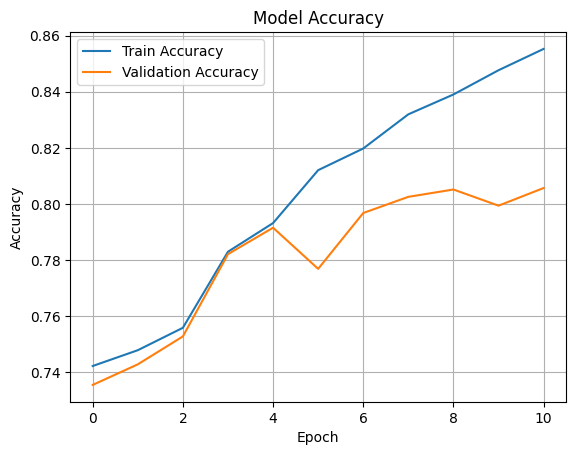

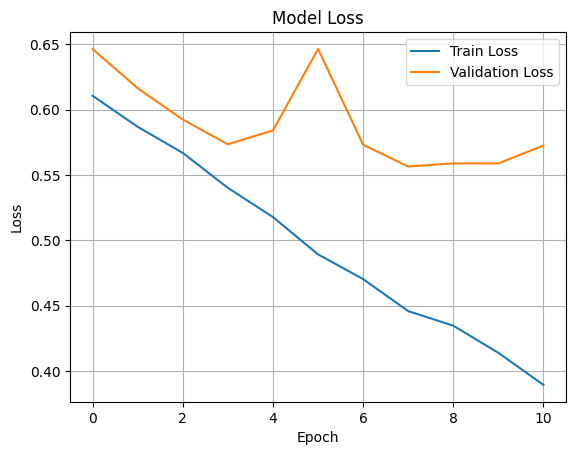

In [25]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Confusion Matrix

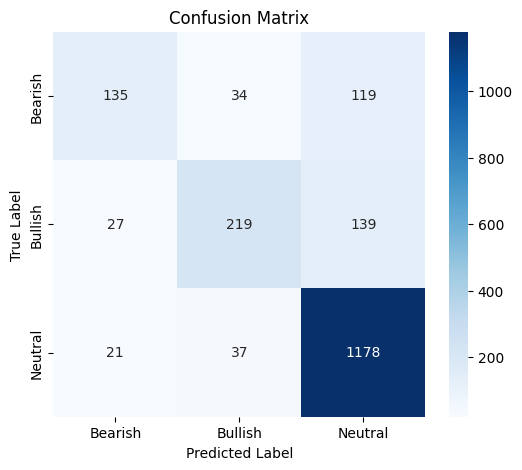

In [30]:
cm = confusion_matrix(y_test_true, y_pred_classes)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bearish', 'Bullish', 'Neutral'],
            yticklabels=['Bearish', 'Bullish', 'Neutral'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [35]:
report = classification_report(y_test_true, y_pred_classes, digits=4, output_dict=True)

# Extrair Macro F1 e Accuracy
macro_f1 = report['macro avg']['f1-score']
accuracy = accuracy_score(y_test_true, y_pred_classes)

print(f"\n--- LSTM + GloVe ---")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")


--- LSTM + GloVe ---
Macro F1: 0.7013
Accuracy: 0.8025
